In [1]:
# from utils import datagenerator
from utils.shape import ShapesConfig
from coco import CocoDataset
import matplotlib.pyplot as plt
from utils.datagenerator import data_generator

from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
import keras.layers as KL
import keras.models as KM
import tensorflow as tf
import numpy as np

from utils.BilinearUpSampling import *
from utils.Mylayers import *
# import utils

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[56 56]
 [28 28]
 [14 14]
 [ 7  7]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  224
IMAGE_MIN_DIM                  224
IMAGE_PADDING                  True
IMAGE_SHAPE                    [224 224   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         20

In [3]:
dataset_train = CocoDataset()
dataset_train.load_coco('coco_dataset/', "val")
dataset_train.prepare()

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [4]:
train_generator = data_generator(dataset_train, config, shuffle=True,batch_size=config.BATCH_SIZE,use_background=False)

In [5]:
############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'


    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = KL.BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = KL.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, input_shape = None, stage5=False,include_top=True,weights='imagenet'):
    assert architecture in ["resnet50", "resnet101"]
    pool_size = (2,2)

    input_shape = _obtain_input_shape(input_shape,
                                     default_size=224,
                                     min_size=197,
                                     data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)
    print("input_image : {} ".format(input_image))
     # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = KL.BatchNormalization(axis=3, name='bn_conv1')(x)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
#     C1 = x , mask_1 = MaxPoolingWithArgmax2D((3,3))(x)
   
    
    print("C1 : {} ".format(C1))
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    #C2 , mask_2 = MaxPoolingWithArgmax2D((2,2))(x)
    print("C2 : {} ".format(C2))
    
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    #C3 , mask_3 = MaxPoolingWithArgmax2D((2,2))(x)
    print("C3 : {} ".format(C3))
    
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i))
    C4 = x
    
    #C4 , mask_4 = MaxPoolingWithArgmax2D((2,2))(x)
    
    print("C4 : {} ".format(C4))
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    else:
        C5 = None
        
#     C5 , mask_5 = MaxPoolingWithArgmax2D((2,2))(x)
    print("C5 : {} ".format(C5))
    
    
    
    xfc = KL.AveragePooling2D((7,7), name='avg_pool')(x)
    xfc = KL.Flatten()(xfc)
    print("xfc Flatten : {} ".format(xfc))
    xfc_out = xfc
    model6 = KM.Model(input_image,xfc)
    
#     xfc = KL.Dense(2048, activation='softmax', name='fc1000')(xfc)
    xfc = KL.Dense(1000, activation='softmax', name='fc1000')(xfc)
    print("xfc Dense : {} ".format(xfc))    

    model = KM.Model(input_image,xfc)
    weights_path = 'keras_resnet50_weight.hdf5'
    model.load_weights(weights_path,by_name=True)
    
    return model,C1,C2,C3,C4,C5#,mask_1#,mask_2,mask_3,mask_4

In [6]:
def side_branch(x, factor):
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', use_bias=False, activation=None)(x)

    return x


In [47]:
def generate_model(input_image):
    #resnet
    res_model,C1,C2,C3,C4,C5 = resnet_graph(input_image, "resnet50", stage5=True)
    
#     for layer in res_model.layers:
#         layer.trainable=False
    
    S1 = side_branch(C1,1)
    S2 = side_branch(C2,1)
    S3 = side_branch(C3,2)
    S4 = side_branch(C4,4)
    S5 = side_branch(C5,8)
    
    
    ###########################################################
    # 7*7 layer
    ###########################################################
    
    #7*7*2048
    y1 = KL.Conv2D(2048, (2, 2) , padding="same")(C5)
    y1 = KL.BatchNormalization(axis=3)(y1)
    y1 = KL.Activation('relu')(y1)
    print("y1 : {} ".format(y1))
    
    y1 = KL.Conv2D(81, (2, 2) , padding="same")(y1)
    y1 = KL.BatchNormalization(axis=3)(y1)
    y1 = KL.Activation('relu')(y1)
        
#     y1_pooling = KL.UpSampling2D(size=(8, 8))(y1)
    y1_pooling = BilinearUpSampling2D(target_size=(56, 56))(y1)
    y1_pooling = KL.BatchNormalization(axis=3)(y1_pooling)
    y1_pooling = KL.Activation('relu')(y1_pooling)
    print("y1_pooling : {} ".format(y1_pooling))
    
#     tmp_pooling = KL.UpSampling2D(size=(2, 2))(y1)
    tmp_pooling = BilinearUpSampling2D(target_size=(14, 14))(y1)
    tmp_pooling = KL.BatchNormalization(axis=3)(tmp_pooling)
    tmp_pooling = KL.Activation('relu')(tmp_pooling)
    
    ###########################################################
    # 14*14 layer
    ###########################################################
    
    #14*14*1024
    y2 = KL.Conv2D(1024, (2, 2) , padding="same")(C4)
    y2 = KL.BatchNormalization(axis=3)(y2)
    y2 = KL.Activation('relu')(y2)
    print("y2 : {} ".format(y2))
    
    #14*14*81
    y2 = KL.Conv2D(81, (2, 2) , padding="same")(y2)
    y2 = KL.BatchNormalization(axis=3)(y2)
    y2 = KL.Activation('relu')(y2)
    print("y2 : {} ".format(y2))
    
    y2_pooling = BilinearUpSampling2D(target_size=(56, 56))(y2)
    y2_pooling = KL.BatchNormalization(axis=3)(y2_pooling)
    y2_pooling = KL.Activation('relu')(y2_pooling)
    print("y2_pooling : {} ".format(y2_pooling))
    
    y2 = KL.concatenate([y2,tmp_pooling])
    y2 = KL.Conv2D(81, (2, 2) , padding="same")(y2)
    y2 = KL.BatchNormalization(axis=3)(y2)
    y2 = KL.Activation('relu')(y2)
    print("y2 : {} ".format(y2))
    
    tmp_pooling = BilinearUpSampling2D(target_size=(28, 28))(y2)
    tmp_pooling = KL.BatchNormalization(axis=3)(tmp_pooling)
    tmp_pooling = KL.Activation('relu')(tmp_pooling)
    
    
    ###########################################################
    # 28*28 layer
    ###########################################################
    
    
    #28*28*512
    y3 = KL.Conv2D(512, (2, 2) , padding="same")(C3)
    y3 = KL.BatchNormalization(axis=3)(y3)
    y3 = KL.Activation('relu')(y3)
    print("y3 : {} ".format(y3))
    
    #28*28*81
    y3 = KL.Conv2D(81, (2, 2) , padding="same")(y3)
    y3 = KL.BatchNormalization(axis=3)(y3)
    y3 = KL.Activation('relu')(y3)
    print("y3 : {} ".format(y3))
    
    y3_pooling = BilinearUpSampling2D(target_size=(56, 56))(y3)
    y3_pooling = KL.BatchNormalization(axis=3)(y3_pooling)
    y3_pooling = KL.Activation('relu')(y3_pooling)
    print("y3_pooling : {} ".format(y3_pooling))
    
    y3 = KL.concatenate([y3,tmp_pooling])
    y3 = KL.Conv2D(81, (2, 2) , padding="same")(y3)
    y3 = KL.BatchNormalization(axis=3)(y3)
    y3 = KL.Activation('relu')(y3)
    print("y3 : {} ".format(y3))
    
    tmp_pooling = BilinearUpSampling2D(target_size=(56, 56))(y3)
    tmp_pooling = KL.BatchNormalization(axis=3)(tmp_pooling)
    tmp_pooling = KL.Activation('relu')(tmp_pooling)
    
    
    ###########################################################
    # 56*56 layer
    ###########################################################
        
    #56*56*256
    y4 = KL.Conv2D(256, (2, 2) , padding="same")(C2)
    y4 = KL.BatchNormalization(axis=3)(y4)
    y4 = KL.Activation('relu')(y4)
    print("y4 : {} ".format(y4))
    
    #56*56*81
    y4 = KL.Conv2D(81, (2, 2) , padding="same")(y4)
    y4 = KL.BatchNormalization(axis=3)(y4)
    y4 = KL.Activation('relu')(y4)
    print("y4 : {} ".format(y4))
    
    t = KL.concatenate([S2,S3,S4,S5])
    
    y4 = KL.concatenate([t, y4,tmp_pooling,y1_pooling,y2_pooling,y3_pooling])
    y4 = KL.Conv2D(81, (2, 2) , padding="same")(y4)
    y4 = KL.BatchNormalization(axis=3)(y4)
    y4 = KL.Activation('relu')(y4)
    print("y4 : {} ".format(y4))
    
    y4 = KL.Conv2D(81, (1, 1) , padding="same")(y4)
    y4 = KL.BatchNormalization(axis=3)(y4)
    y4 = KL.Activation('relu')(y4)
    print("y4 : {} ".format(y4))
    
    
    y = KL.Reshape((56*56,81) , input_shape= (56,56,81))(y4)
    print("y : {} ".format(y))
    y = KL.Activation('softmax')(y)
    print("y : {} ".format(y))
    
#     y = KL.Permute((2, 1), input_shape=(3136, 81))(y)
#     print("y : {} ".format(y))
    
    model = KM.Model(input_image,y)
    return model

In [48]:
input_image = KL.Input(shape=[224,224,3], name="g_input_data")
g_model = generate_model(input_image)

input_image : Tensor("g_input_data_2:0", shape=(?, 224, 224, 3), dtype=float32) 
C1 : Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 56, 56, 64), dtype=float32) 
C2 : Tensor("res2c_out_2/Relu:0", shape=(?, 56, 56, 256), dtype=float32) 
C3 : Tensor("res3d_out_2/Relu:0", shape=(?, 28, 28, 512), dtype=float32) 
C4 : Tensor("res4f_out_2/Relu:0", shape=(?, 14, 14, 1024), dtype=float32) 
C5 : Tensor("res5c_out_2/Relu:0", shape=(?, 7, 7, 2048), dtype=float32) 
xfc Flatten : Tensor("flatten_3/Reshape:0", shape=(?, ?), dtype=float32) 
xfc Dense : Tensor("fc1000_2/Softmax:0", shape=(?, 1000), dtype=float32) 
y1 : Tensor("activation_138/Relu:0", shape=(?, 7, 7, 2048), dtype=float32) 
y1_pooling : Tensor("activation_140/Relu:0", shape=(?, 56, 56, 81), dtype=float32) 
y2 : Tensor("activation_142/Relu:0", shape=(?, 14, 14, 1024), dtype=float32) 
y2 : Tensor("activation_143/Relu:0", shape=(?, 14, 14, 81), dtype=float32) 
y2_pooling : Tensor("activation_144/Relu:0", shape=(?, 56, 56, 81), dtype=float32

In [49]:
g_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_data (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           g_input_data[0][0]               
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [50]:
_EPSILON = 1e-7
def epsilon():
    """Returns the value of the fuzz factor used in numeric expressions.
    # Returns
        A float.
    # Example
    ```python
        >>> keras.backend.epsilon()
        1e-07
    ```
    """
    return _EPSILON

def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
        x: An object to be converted (numpy array, list, tensors).
        dtype: The destination type.
    # Returns
        A tensor.
    """
    return tf.convert_to_tensor(x, dtype=dtype)

In [51]:
def loss_notrans(y_true,y_pred):
    
    loss = y_true * tf.log(y_pred) + (1 - y_true) * tf.log(1 - y_pred)
    print(loss)
    
    return -loss

In [57]:
def loss_func(y_true,y_pred):
    
    #transpose
    y_true = tf.transpose(y_true,[0,2,1])
    y_pred = tf.transpose(y_pred,[0,2,1])
    
    #let sum equal 1
    y_pred /= tf.reduce_sum(y_pred,axis=len(y_pred.get_shape()) - 1,keep_dims=True)

    # manual computation of crossentropy
    _epsilon = _to_tensor(epsilon(), y_pred.dtype.base_dtype)    
    
    #set y_ture range
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    #set y_ture 0 to _epsilon
    y_true = tf.clip_by_value(y_true, _epsilon, 1)
    
        
    positive_loss = y_true * tf.log(y_pred) #+ y_pred * tf.log(y_true)
    negetive_loss = (1 - y_true) * tf.log(1 - y_pred)# + (1 - y_pred) * tf.log(1 - y_true)

    positive_loss = tf.reduce_sum(positive_loss,axis=-1)
    negetive_loss = tf.reduce_sum(negetive_loss,axis=-1)
    
    #check if has this class
    check = tf.reduce_sum(y_true,axis=-1)
    print(check)

    IOU_p = tf.sigmoid(y_pred)    
    IOU_p = tf.greater(IOU_p,tf.reduce_mean(IOU_p))
    IOU_p = tf.cast(IOU_p,tf.bool)
    IOU_t = tf.cast(y_true,tf.bool)

    
    IOU_and = tf.logical_and(IOU_p , IOU_t)
    IOU_or = tf.logical_or(IOU_p , IOU_t)
    IOU_and = tf.cast(IOU_and,tf.float32)
    IOU_or = tf.cast(IOU_or,tf.float32)
    
    IOU_and = tf.reduce_sum(IOU_and,axis=-1)
    IOU_or = tf.reduce_sum(IOU_or,axis=-1)
    print(IOU_and)
    
    IOU = tf.divide(IOU_and,IOU_or)
    
    print(IOU)
    IOU = tf.clip_by_value(IOU,1/1000,1)
    
    
    positive_loss = tf.divide(positive_loss,IOU)
    negetive_loss = tf.multiply(negetive_loss,3136)
    
#     tmp_loss = K.binary_crossentropy(target=y_true, output=y_pred)
#     tmp_loss = tf.reduce_mean(tmp_loss,axis=-1)
#     print(tf.equal(check,0))
    
    loss = tf.where(tf.equal(check,0),negetive_loss,positive_loss)

    
    print(loss)
    
    return -loss

In [58]:
from keras.optimizers import SGD,Adam
sgd = SGD(lr = config.LEARNING_RATE, decay=1e-6, momentum=config.LEARNING_MOMENTUM, nesterov=True)

In [59]:
test_model = g_model

In [60]:
# g_model.compile(optimizer=sgd, loss= 'categorical_crossentropy', metrics=['accuracy'])
# g_model.compile(optimizer=sgd, loss= 'binary_crossentropy_with_logits', metrics=['accuracy'])
test_model.compile(optimizer=sgd, loss= loss_func, metrics=['accuracy'])
# test_model.compile(optimizer=sgd, loss= loss_notrans, metrics=['accuracy'])

Tensor("loss_3/activation_156_loss/Sum_3:0", shape=(?, ?), dtype=float32)
Tensor("loss_3/activation_156_loss/Sum_4:0", shape=(?, 81), dtype=float32)
Tensor("loss_3/activation_156_loss/truediv_1:0", shape=(?, 81), dtype=float32)
Tensor("loss_3/activation_156_loss/Select:0", shape=(?, 81), dtype=float32)


In [84]:
test_model.fit_generator(train_generator,
            epochs=40,
            steps_per_epoch=100)

Epoch 1/40


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 68s 683ms/step - loss: 15.0634 - acc: 1.1958e-05
Epoch 2/40
100/100 [==============================] - 68s 682ms/step - loss: 15.8800 - acc: 1.6821e-04
Epoch 3/40
100/100 [==============================] - 68s 684ms/step - loss: 16.0616 - acc: 2.3916e-05
Epoch 4/40
100/100 [==============================] - 68s 683ms/step - loss: 16.2914 - acc: 0.0000e+00
Epoch 5/40
100/100 [==============================] - 68s 684ms/step - loss: 16.1250 - acc: 0.0000e+00
Epoch 6/40
100/100 [==============================] - 68s 684ms/step - loss: 19.3635 - acc: 2.0727e-05
Epoch 7/40
100/100 [==============================] - 68s 684ms/step - loss: 18.2695 - acc: 1.3353e-04
Epoch 8/40
100/100 [==============================] - 68s 684ms/step - loss: 16.5202 - acc: 2.2321e-05
Epoch 9/40
100/100 [==============================] - 68s 684ms/step - loss: 19.9241 - acc: 1.7020e-04
Epoch 10/40
100/100 [==============================] - 68s 684ms/step - loss: 18.007

KeyboardInterrupt: 

In [85]:
test_model.save_weights("test.hdf5",overwrite=True)

KeyboardInterrupt: 

# Test

In [86]:
from utils.datagenerator import load_image_gt
import numpy as np
import random

In [113]:
image, gt_class_ids, gt_masks, gt_all_masks = \
                load_image_gt(dataset_train, config, random.randint(0,150), augment=True,
                          use_mini_mask=config.USE_MINI_MASK,use_background=True)

<IPython.core.display.Javascript object>


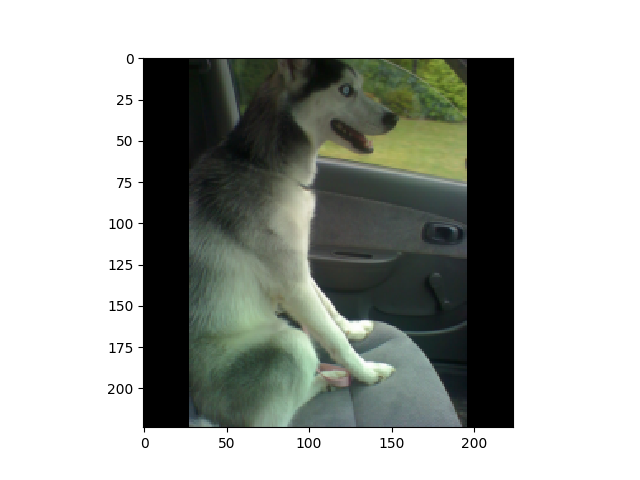

In [114]:
%matplotlib notebook
plt.imshow(image)
plt.show()

In [115]:
gt_class_ids

array([17], dtype=int32)

In [116]:
x = np.expand_dims(image, axis=0)
output_mask = test_model.predict(x)
print(output_mask.shape)
output_mask = np.reshape(output_mask[0,:,:],(56,56,81))

(1, 3136, 81)


<IPython.core.display.Javascript object>


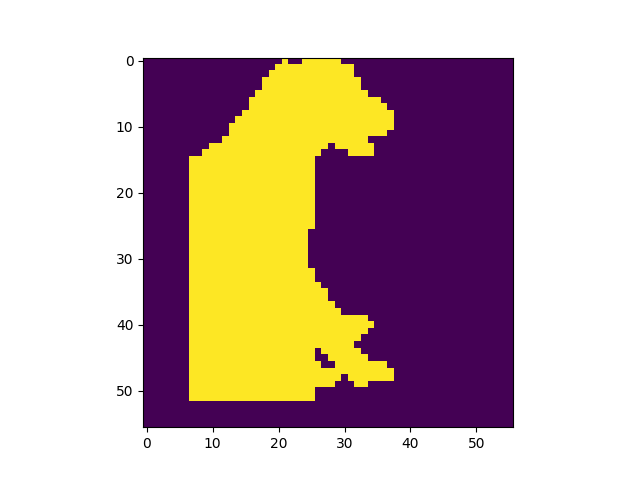

In [117]:
%matplotlib notebook
plt.imshow(gt_masks[:,:,17])
plt.show()

<IPython.core.display.Javascript object>


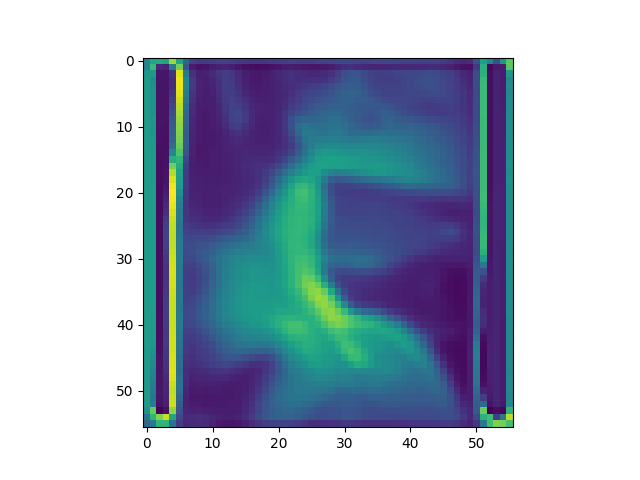

In [118]:
#before train
%matplotlib notebook
plt.imshow(output_mask[:,:,17])
plt.show()